In [1]:
%load_ext autoreload
%autoreload 2

Something was funky with the product space benchmarks I ran: my rewritten sampling/productDT+RF code did a lot worse on randomly-sampled gaussian mixtures. I want to get to the bottom of this.

In [2]:
import embedders
import hyperdt

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INFO: Using numpy backend
INFO: Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO: Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO: Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO: generated new fontManager


In [3]:
# Basic test: 2-D data, distribution of coords

pm = embedders.manifolds.ProductManifold(signature=[(0, 2)])
embedders_points = pm.sample(torch.stack([pm.mu0] * 10_000))

wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(10_000, 1)
hyperdt_points = wn.sample_points(means=np.array([[1., 0., 0.]]), covs=np.eye(2).reshape(1,2,2), classes=[0]*10_000)

Text(0.5, 1.0, 'Distribution of y-coordinates')

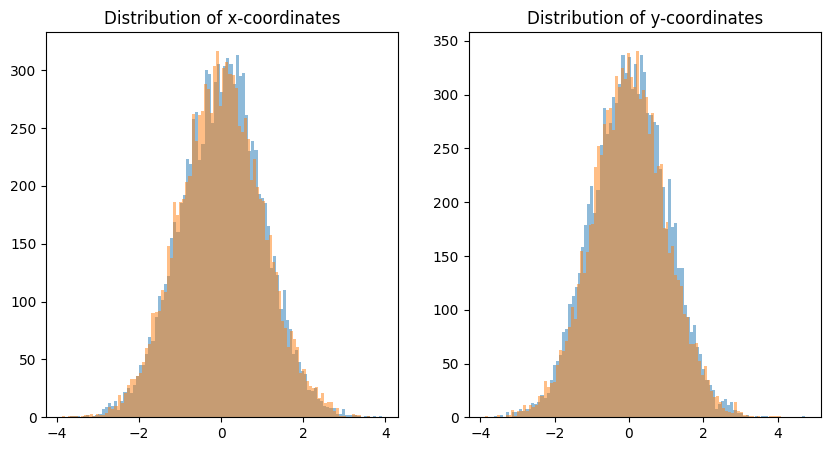

In [4]:
# Check distribution of coordinates

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(embedders_points[:, 0].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
axs[0].hist(hyperdt_points[:, 1], bins=100, alpha=0.5, label='Wrapped normal')
axs[0].set_title('Distribution of x-coordinates')

axs[1].hist(embedders_points[:, 1].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
axs[1].hist(hyperdt_points[:, 2], bins=100, alpha=0.5, label='Wrapped normal')
axs[1].set_title('Distribution of y-coordinates')

torch.Size([10000, 3]) (10000, 3)


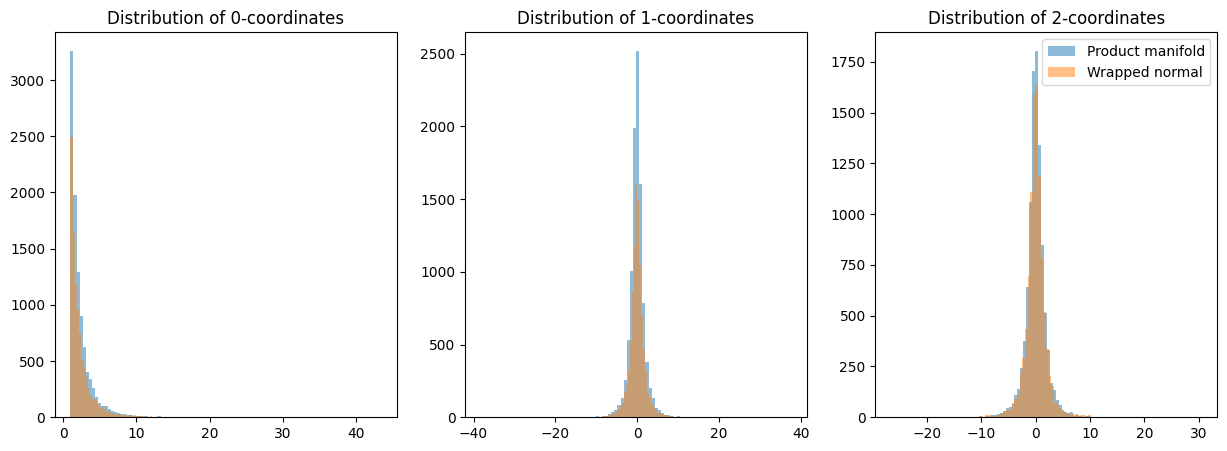

In [5]:
# Try a hyperboloid

def check_curvature(curvature, dims=2):
    pm = embedders.manifolds.ProductManifold(signature=[(curvature, dims)])
    embedders_points = pm.sample(torch.stack([pm.mu0] * 10_000))
    embedders_points = embedders_points / np.sqrt(np.abs(curvature))

    wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(10_000, 1, curvature=curvature)
    hyperdt_points = wn.sample_points(
        means=pm.mu0.detach().numpy().reshape(1,-1), 
        covs=np.eye(pm.dim).reshape(1, pm.dim, pm.dim), 
        classes=[0]*10_000
    )

    print(embedders_points.shape, hyperdt_points.shape)

    # Check distribution of coordinates
    fig, axs = plt.subplots(1, pm.ambient_dim, figsize=(pm.ambient_dim * 5, 5))
    for i in range(3):
        axs[i].hist(embedders_points[:, i].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
        axs[i].hist(hyperdt_points[:, i], bins=100, alpha=0.5, label='Wrapped normal')
        axs[i].set_title(f'Distribution of {i}-coordinates')
    plt.legend()
    plt.show()

check_curvature(-1, 2)


torch.Size([10000, 3]) (10000, 3)


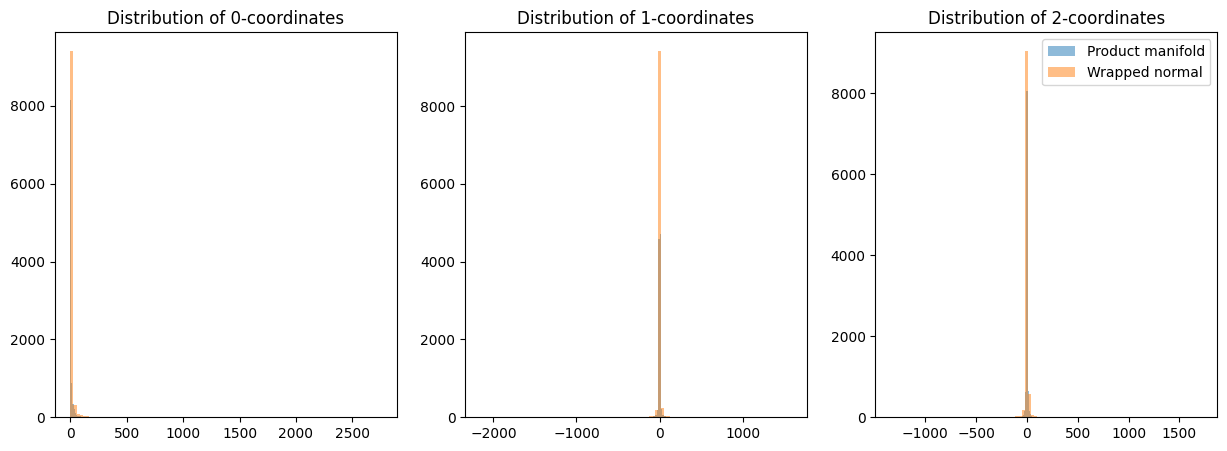

In [6]:
check_curvature(-4, 2)


torch.Size([10000, 3]) (10000, 3)


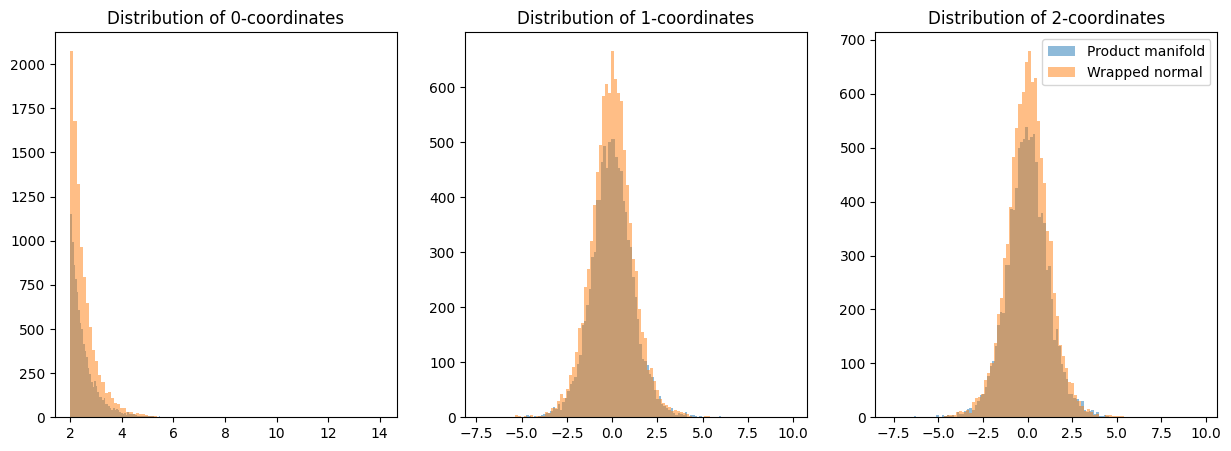

In [7]:
check_curvature(-0.25, 2)


torch.Size([10000, 3]) (10000, 3)


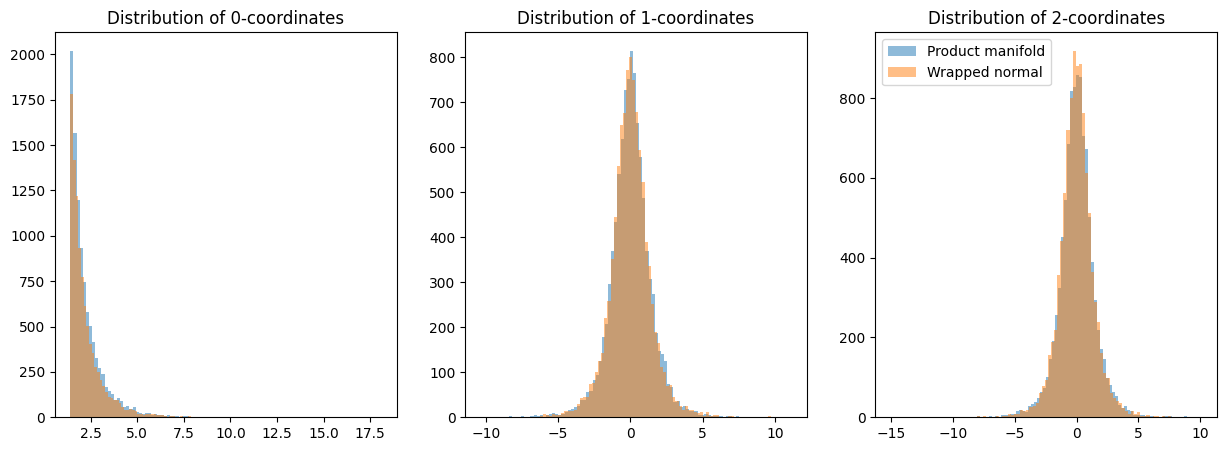

In [8]:
check_curvature(-0.5, 2)


torch.Size([10000, 3]) (10000, 3)


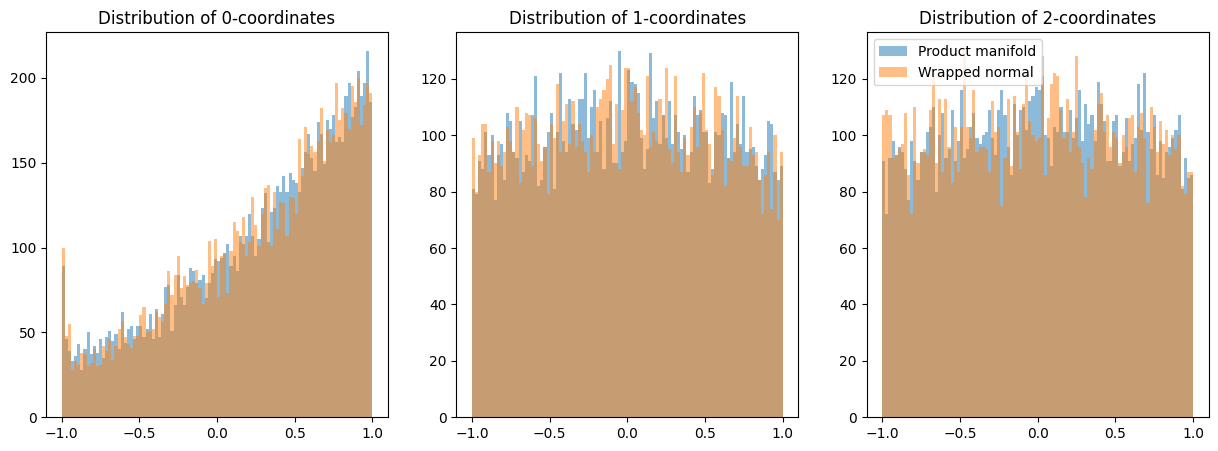

In [9]:
check_curvature(1, 2)

torch.Size([10000, 3]) (10000, 3)


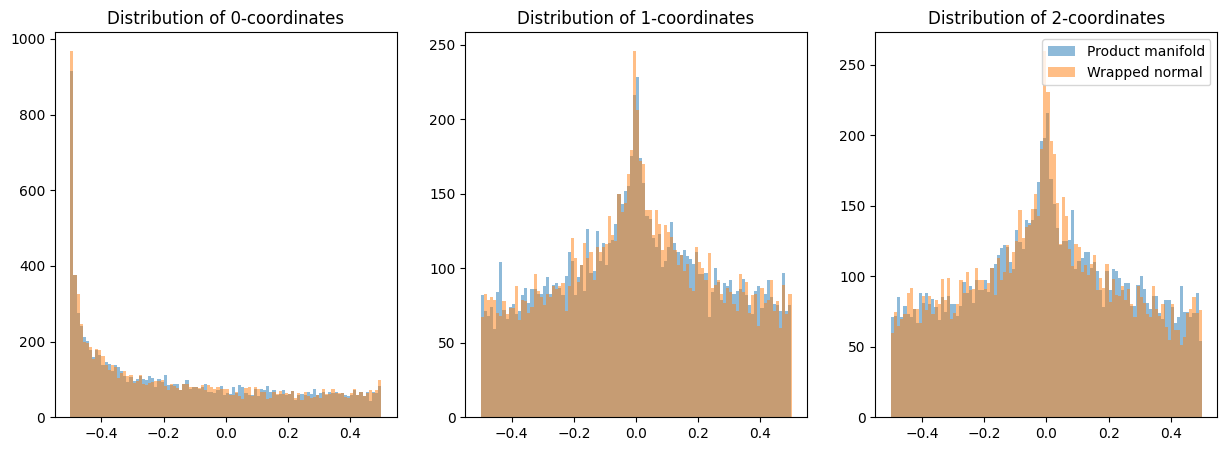

In [10]:
check_curvature(4, 2)

torch.Size([10000, 3]) (10000, 3)


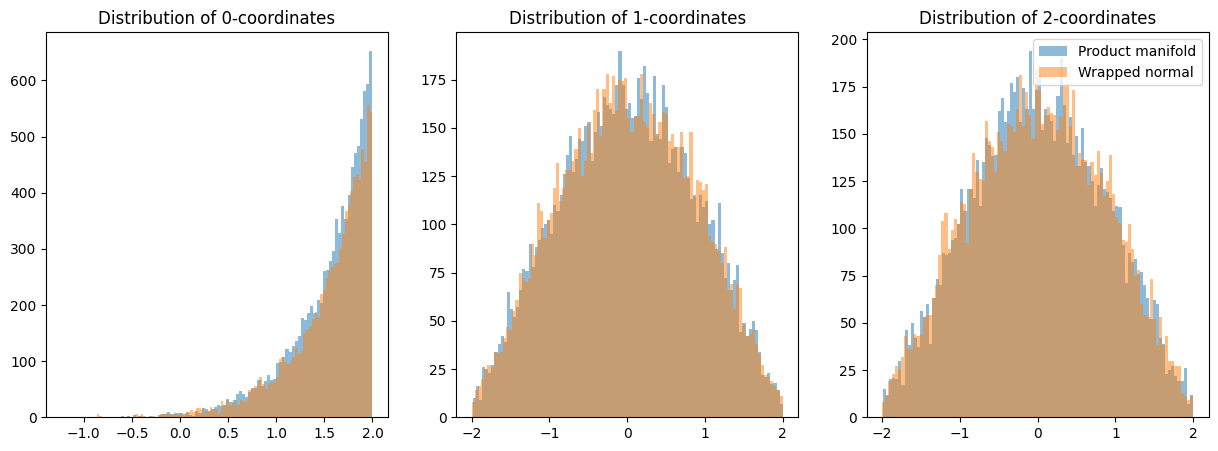

In [11]:
check_curvature(.25, 2)

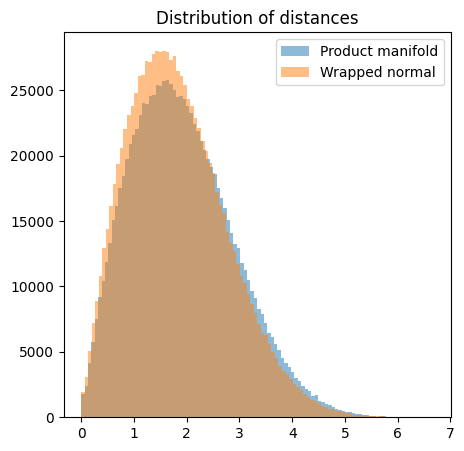

In [12]:
# Try a hyperboloid

def check_pdist(curvature, dims=2):
    pm = embedders.manifolds.ProductManifold(signature=[(curvature, dims)])
    embedders_points = pm.sample(torch.stack([pm.mu0] * 1_000))

    wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(1_000, 1, curvature=curvature)
    hyperdt_points = wn.sample_points(
        means=pm.mu0.detach().numpy().reshape(1,-1), 
        covs=np.eye(pm.dim).reshape(1, pm.dim, pm.dim), 
        classes=[0]*1_000
    )

    embedders_dists = pm.pdist(embedders_points)
    hyperdt_dists = pm.pdist(torch.tensor(hyperdt_points) * np.sqrt(np.abs(curvature)))

    # Check distribution of coordinates
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(embedders_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Product manifold')
    ax.hist(hyperdt_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Wrapped normal')
    ax.set_title(f'Distribution of distances')
    plt.legend()
    plt.show()

check_pdist(-1, 2)


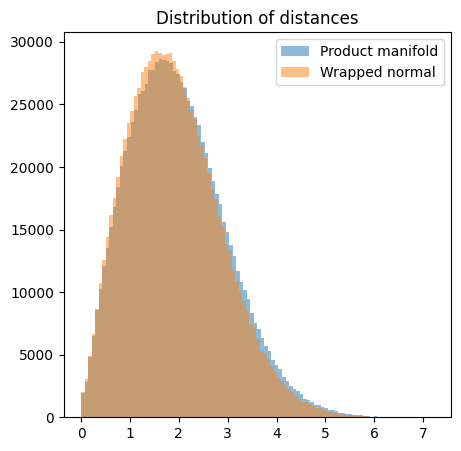

In [13]:
check_pdist(-2, 2)

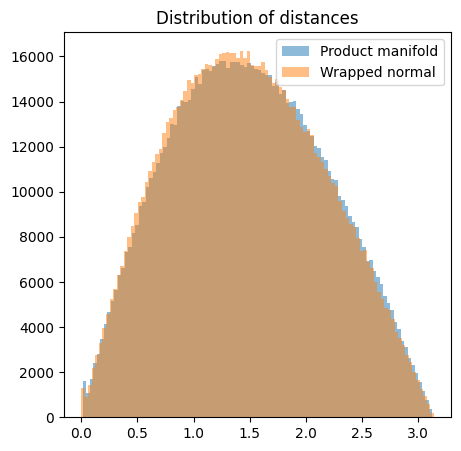

In [14]:
check_pdist(1, 2)

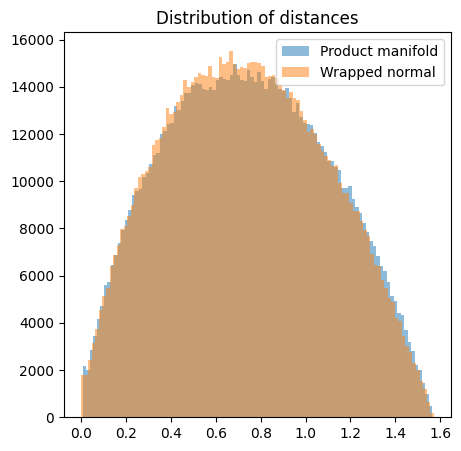

In [15]:
check_pdist(4, 2)

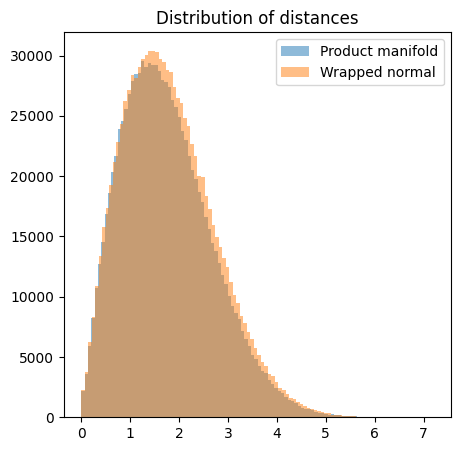

In [16]:
check_pdist(-.25, 2)

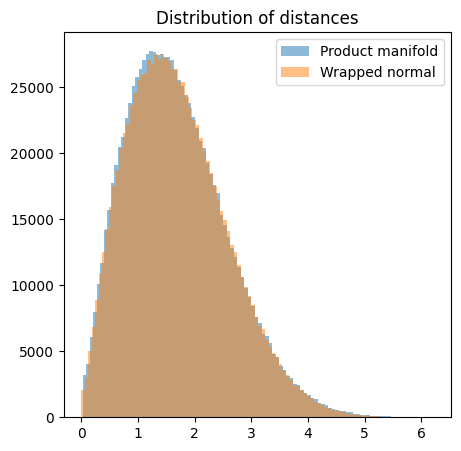

In [17]:
check_pdist(.25, 2)

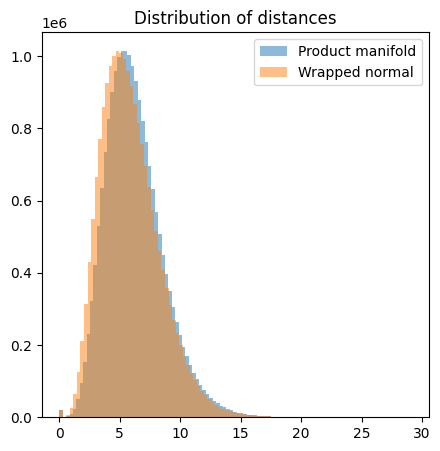

In [54]:
# Try a hyperboloid

def check_signature(signature, n_points=1_000, n_iters=20):
    embedders_dists_all, hyperdt_dists_all = [], []
    for _ in range(n_iters):
        pm = embedders.manifolds.ProductManifold(signature=signature)
        # embedders_points = pm.sample(torch.stack([pm.mu0] * 1_000))
        embedders_points, _ = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm, num_points=n_points, num_classes=1, cov_scale_means=1., cov_scale_points=1.,
        )

        ps = hyperdt.product_space_DT.ProductSpace(signature=[(dim, curvature) for (curvature, dim) in signature])
        ps.sample_clusters(num_points=n_points, num_classes=1, cov_scale=1.)
        hyperdt_points = ps.X

        embedders_dists = pm.pdist(embedders_points)
        hyperdt_dists = pm.pdist(torch.tensor(hyperdt_points))

        embedders_dists_all.append(embedders_dists)
        hyperdt_dists_all.append(hyperdt_dists)
    
    # Flatten dists out
    embedders_dists = torch.stack(embedders_dists_all).detach().cpu().numpy().flatten()
    hyperdt_dists = torch.stack(hyperdt_dists_all).detach().cpu().numpy().flatten()

    # Check distribution of coordinates
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(embedders_dists, bins=100, alpha=0.5, label='Product manifold')
    ax.hist(hyperdt_dists, bins=100, alpha=0.5, label='Wrapped normal')
    ax.set_title(f'Distribution of distances')
    plt.legend()
    plt.show()

check_signature([(-1, 2), (-1, 2), (-1, 2)])

In [67]:
# Ok, these seem pretty close now. Let's re-do some of the benchmarks

from tqdm.notebook import tqdm

import pandas as pd
import embedders
import hyperdt

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

results2 = []

N_POINTS = 1_000
N_TRIALS = 20
N_CLASSES = 4
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.3

SIGNATURES = [
    # [(-1, 10)],
    # [(0, 10)],
    # [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

SIGNATURES_STR = [
    # "H(-1, 10)",
    # "E(0, 10)",
    # "S(1, 10)",
    "H(-1, 5)^2",
    "S(1, 5)^2",
    "H(-1, 5) x \n S(1, 5)",
    "H(-1, 2)^5",
    "S(1, 2)^5",
    "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
]

device = "cuda" if torch.cuda.is_available() else "cpu"

my_tqdm = tqdm(total=len(SIGNATURES) * N_TRIALS)
for i, signature in enumerate(SIGNATURES):
    for seed in range(N_TRIALS):
        # Ensure unique seed per trial
        seed = seed + N_TRIALS * i
        pm = embedders.manifolds.ProductManifold(signature=signature, device=device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            cov_scale_means=COV_SCALE_MEANS,
            cov_scale_points=COV_SCALE_POINTS,
        )
        accs = embedders.benchmarks.benchmark(
            X, 
            y,
            pm, 
            device=device, 
            classifiers=[
                "sklearn_dt", 
                "tangent_dt", 
                "product_dt", 
                "product_dt_legacy", 
                "sklearn_rf", 
                "tangent_rf", 
                "product_rf", 
                "product_rf_legacy"
            ], 
            score="accuracy"
        )
        accs["signature"] = SIGNATURES_STR[i]
        accs["seed"] = seed
        results2.append(accs)

        my_tqdm.update(1)

results2 = pd.DataFrame(results2)

# results2.to_csv(
#     "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/signature_benchmarks.csv", index=False
# )

  0%|          | 0/120 [00:00<?, ?it/s]

In [66]:
# Turn table into 95% confidence intervals with p-values
import numpy as np
from scipy.stats import ttest_rel

start_str = """
\\begin{tabular}{cccccccc}
    \\toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
    \\hline
"""

SIGNATURES_LATEX = [
    # "\\H{10}",
    # "\\E{10}",
    # "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

suffix = ""


print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    # for model in ["product_dt", "sklearn_dt", "tangent_dt", "product_rf", "sklearn_rf", "tangent_rf"]:
    for model in [f"product_dt{suffix}", "sklearn_dt", "tangent_dt"]:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        pre, post = model.split("_")[0], model.split("_")[1]
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        if mean > _p.mean() and ttest_rel(r[model], _p).pvalue < 0.05:
            asts.append("*")
        if mean > _e.mean() and ttest_rel(r[model], _e).pvalue < 0.05:
            asts.append("\dagger")
        if mean > _t.mean() and ttest_rel(r[model], _t).pvalue < 0.05:
            asts.append("\ddagger")
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)


\begin{tabular}{cccccccc}
    \toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\
    \hline



TypeError: list indices must be integers or slices, not str

In [ ]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib
matplotlib.use("pgf")
import matplotlib.pyplot as plt
import numpy as np
# import tikzplotlib


# # Load results
# results = pd.read_csv(
#     "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks.csv"
# # )
# CURVATURES = [-4, -2, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]

from scipy.stats import ttest_rel

# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt"]
model_names1 = ["Product DT", "Euclidean DT (ambient)", "Euclidean DT (tangent plane)"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf"]
model_names2 = ["Product RF", "Euclidean RF (ambient)", "Euclidean RF (tangent plane)"]
colors = ["C0", "C1", "C2"]

# Initialize plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
x_vals = np.arange(len(SIGNATURES)) * (len(models1) + 1)

for ax, models, model_names in zip(axs, [models1, models2], [model_names1, model_names2]):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["signature"] == sig][model] for sig in SIGNATURES_STR],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=2),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=2)
        plt.setp(bp["medians"], color="black", linewidth=2)
        plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

        bps.append(bp)

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(SIGNATURES)  # How many annotations per curvature
    for i, j in [(0, 1), (1, 2), (0, 2)]:
        results_K = [results[results["signature"] == sig] for sig in SIGNATURES_STR]
        p_vals = [ttest_rel(res[models[i]], res[models[j]]).pvalue for res in results_K]

        for k, p_val in enumerate(p_vals):
            if p_val < 0.05:
                x1, x2 = x_vals[k] + i, x_vals[k] + j
                y = results[results["signature"] == SIGNATURES_STR[k]][models].max().max() + 0.04 * (heights[k] + 1)
                ax.text(
                    s="*", x=(x1 + x2) / 2, y=y, ha="center", va="center", color="black", fontdict={"weight": "bold"}
                )
                ax.plot([x1, x1, x2, x2], [y - 0.02, y - 0.01, y - 0.01, y - 0.02], lw=2, color="black")
                heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-ticks
    ax.set_ylabel("F1 Score", fontsize=14)
    # ax.set_title("D", fontsize=16)
    ax.set_xticks(x_vals + 1, SIGNATURES_STR, fontsize=14)
    ax.legend([bp["boxes"][0] for bp in bps], model_names, loc="upper right", fontsize=14, frameon=False)
    # ax.set_xlabel("Curvature", fontsize=14)
    ax.tick_params(axis="y", labelsize=14)

axs[0].set_title("Decision Trees", fontsize=16)
axs[1].set_title("Random Forests", fontsize=16)
axs[1].set_xlabel("Curvature", fontsize=14)

plt.xlim(-1, len(CURVATURES) * (len(models1) + 1))

# Transparent
plt.tight_layout()
# plt.show()

# Save as pdf
# plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_dt.pdf")
# plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_mixed.pdf")

# Save as tikz
plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_mixed.pgf")